##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import TensorFlow and other libraries

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import glob
import tqdm
import os
from os import listdir
from os.path import isfile, join



import pandas as pd
from urllib.request import urlopen,urlretrieve
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [10]:
def reshape_img(fl):
    fl_ = np.zeros((256,256,fl.shape[0]))
    for c in range(fl.shape[0]):
        fl_[:,:,c] = fl[c,:,:]
    return fl_

def reshape_img_arr(img):
    img_ = np.zeros((256, 256, img.shape[1]))
    for c in range(img.shape[1]):
        img_[:,:,:,c] = img[:,c,:,:]
    return img_

def clean_3d(img):
    img_ = np.zeros_like(img)
    for c in range(img.shape[-1]):
        img_[:,:,c] = img[:,:,c] - img[:,:,c].min()
        img_[:,:,c] = img_[:,:,c]/img_[:,:,c].max()
    return img_

In [11]:
def load_img_folder(folder, pattern="*20X*.npy"):
    br_arr = []; fl_arr = []
    for img_file in tqdm.tqdm(glob.glob(folder+pattern)):
        data = np.load(img_file,allow_pickle=True)
        for p in range(data.shape[0]):
            try:
                br = reshape_img(data[p,:,0,:,:])
                br = clean_3d(br)
                fl = clean_3d(reshape_img(data[p,1,1:,:,:]))
                br_arr.append(br)
                fl_arr.append(fl)
            except IndexError:
                print("IndexError in: " + img_file)
                break
    return np.array(br_arr), np.array(fl_arr)

In [12]:
# br_arr, fl_arr = load_img_folder("../../shared/patches/raw_20X/", pattern="20X.npy")
from os import listdir
from os.path import isfile, join
mypath="/project/hackathon/hackers03/shared/raw_3z_20X/"
br_arr, fl_arr = load_img_folder(mypath)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:09<00:17,  9.00s/it]

 67%|██████▋   | 2/3 [00:28<00:12, 12.21s/it]

100%|██████████| 3/3 [00:34<00:00, 11.51s/it]


In [15]:
def get_labels(fl_arr):
    fucci_ims_center = [i[110:140,110:140,:] for i in fl_arr]

    labels = np.array([float(np.mean(i[:,:,0]) < np.mean(i[:,:,1])) for i in fucci_ims_center])
    return labels
X=br_arr
Y=get_labels(fl_arr)
print(X,Y)

[[[[0.121332   0.11094933 0.14414896]
   [0.13089634 0.1130363  0.13782351]
   [0.12593891 0.12259755 0.12530625]
   ...
   [0.17891838 0.17215104 0.18383892]
   [0.15933901 0.16569598 0.17791438]
   [0.15272909 0.15390215 0.17034166]]

  [[0.11402103 0.11633663 0.12606352]
   [0.11427141 0.11837507 0.12958261]
   [0.12043065 0.12614056 0.12855806]
   ...
   [0.16419629 0.17040381 0.18223529]
   [0.16329494 0.17127742 0.17809257]
   [0.15638458 0.15390215 0.17034166]]

  [[0.12348523 0.12012231 0.12628625]
   [0.11607411 0.13274122 0.13283442]
   [0.11492238 0.11721025 0.13180988]
   ...
   [0.17135704 0.17370414 0.18851619]
   [0.1688032  0.17831489 0.19114437]
   [0.16034051 0.15404776 0.17702348]]

  ...

  [[0.12874311 0.13599301 0.14414896]
   [0.13835754 0.12740245 0.14766805]
   [0.13154732 0.12793632 0.14160987]
   ...
   [0.1344016  0.12007377 0.13109715]
   [0.13555333 0.13012036 0.13541806]
   [0.12158237 0.12720831 0.13929351]]

  [[0.1323986  0.14671908 0.14735623]
   [0.1

(1944, 256, 256, 3)
0.0


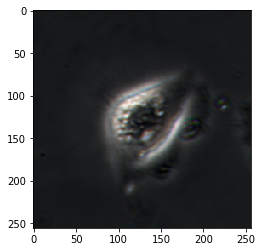

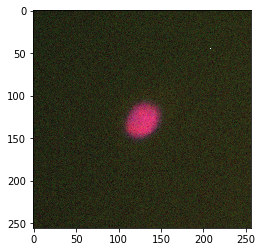

In [16]:
# Show just the first image patch in the sequence
print(br_arr.shape)
# for i in range(10):
i=89
br = br_arr[i,:]
fl = fl_arr[i,:]
plt.figure()
plt.imshow(br)
plt.figure()
plt.imshow(fl)
print(Y[i])

In [17]:
BUFFER_SIZE = 1000
BATCH_SIZE = 200
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [18]:
def load_image_train():
    for i in range(br_arr.shape[0]):
        br_image = tf.cast(br_arr[i,:,:,:],tf.float32)
        fl_image  = tf.cast(fl_arr[i,:,:,:],tf.float32)
        br_image, fl_image = random_jitter(br_image, fl_image)
        br_image, fl_image = normalize(br_image, fl_image)
        yield br_image, fl_image

In [19]:
def resize(br_image, fl_image, height, width):
  br_image = tf.image.resize(br_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  fl_image = tf.image.resize(fl_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return br_image, fl_image

In [20]:
def random_crop(br_image, fl_image):
  stacked_image = tf.stack([br_image, fl_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [21]:
# normalizing the images to [-1, 1]
def normalize(br_image, fl_image):
    br_image = (br_image*2) - 1
    fl_image = (fl_image*2) - 1

    return br_image, fl_image

In [22]:
@tf.function()
def random_jitter(br_image, fl_image):
  # resizing to 314 x 314 x 3
  br_image, fl_image = resize(br_image, fl_image, 314, 314)
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
  # randomly cropping to 256 x 256 x 3
  br_image, fl_image = random_crop(br_image, fl_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    br_image = tf.image.flip_left_right(br_image)
    fl_image = tf.image.flip_left_right(fl_image)

  if tf.random.uniform(()) > 0.5:
    # random up-down mirror
    br_image = tf.image.flip_up_down(br_image)
    fl_image = tf.image.flip_up_down(fl_image)
    
  return br_image, fl_image

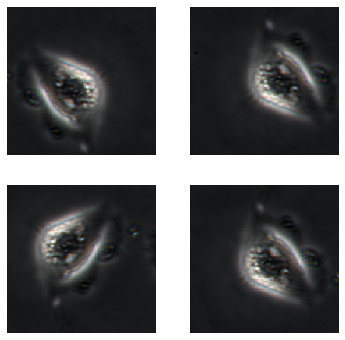

In [24]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_br, rj_fl = random_jitter(br, fl)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_br)
  plt.axis('off')
plt.show()

## Input Pipeline

In [25]:
train_dataset = tf.data.Dataset.from_generator(load_image_train, (tf.float32, tf.float32))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


from keras.utils import to_categorical

Y_train=to_categorical(Y_train)
Y_test=to_categorical(Y_test)







In [26]:
# train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
# train_dataset = train_dataset.map(load_image_train,
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# train_dataset = train_dataset.batch(BATCH_SIZE)

In [27]:
# test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
# test_dataset = test_dataset.map(load_image_test)
# test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [28]:
OUTPUT_CHANNELS = 3

In [ ]:
img_height,img_width = 256,256 
num_classes = 2

from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
    base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)

    from keras.optimizers import SGD, Adam
    # sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=0.0001)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    from keras.callbacks import ModelCheckpoint
    batch_size=20
    
    
    
    
    datagen = ImageDataGenerator()
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
            steps_per_epoch=len(X_train) / batch_size, validation_data=(X_test, Y_test),
            epochs=50, callbacks=[early_stopping_callback])
    model.fit(X[train], Y[train], epochs = 100, batch_size = 20)

    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))




/project/hackathon/hackers03/hack034/.conda/envs/umedhack/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Epoch 1/100
1555/1555 [==============================] - 571s 367ms/step - loss: 1.0627 - accuracy: 0.5318
Epoch 2/100
1555/1555 [==============================] - 543s 349ms/step - loss: 0.9953 - accuracy: 0.5460
Epoch 3/100
1555/1555 [==============================] - 557s 358ms/step - loss: 0.9071 - accuracy: 0.5768
Epoch 4/100
 860/1555 [===============>..............] - ETA: 4:07 - loss: 0.8847 - accuracy: 0.5930

In [ ]:

# preds = model.evaluate(X_test, Y_test)
# print ("Loss = " + str(preds[0]))
# print ("Test Accuracy = " + str(preds[1]))



In [30]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [31]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(br, 0))
print (down_result.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 128, 128, 3)


In [32]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [33]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [34]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


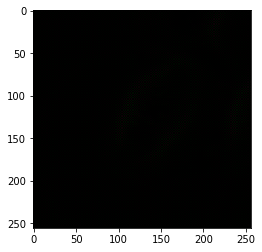

In [35]:
generator = Generator()

gen_output = generator(br[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...],cmap='gray')

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [36]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='br_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



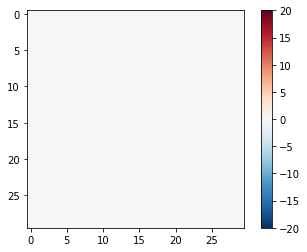

In [37]:
discriminator = Discriminator()
disc_out = discriminator([br[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [38]:
LAMBDA = 100

In [39]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [40]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [41]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Object-based saving)

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the br_image and the generated image as the first input. The second input is the br_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](images/dis.png)


---


![Generator Update Image](images/gen.png)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [44]:
EPOCHS = 21

In [45]:
def generate_images(model, test_input, tar, epoch):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig("gen_images/epoch{}.png".format(epoch))
  plt.show()

In [46]:
@tf.function
def train_step(br_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(br_image, training=True)

    disc_real_output = discriminator([br_image, target], training=True)
    disc_generated_output = discriminator([br_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [47]:
def fit(train_ds, epochs):
  for epoch in tqdm.tqdm(range(epochs)):

    # Train
    for br_image, target in train_ds:
      train_step(br_image, target)

    clear_output(wait=True)
    
    # saving (checkpoint) the model every 20 epochs
    if (epoch) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      for example_input, example_target in train_ds.take(1):
        generate_images(generator, example_input, example_target, epoch)
        plt.savefig('gen_images/epoch{}.png'.format(epoch+1))


In [ ]:
fit(train_dataset, EPOCHS)

  0%|          | 0/21 [00:00<?, ?it/s]